As an investor, the $RecoveryRatio$ is among the most important considerations, more than whether or not a loan defaults. The $RecoveryRation > 1$ (sans fees) means that the investor has made money on the loan.

$$
RecoveryRatio = \frac{total\_pymnt}{loan\_amnt}
$$

An investor can make money on a loan even if it defaults, as illustrated by @fig-default-loans-recovery-ratio.

However, because a very small number of defaulted loans will provide a positive return, we want to avoid these loans.

100%|██████████| 339M/339M [00:02<00:00, 173MB/s]

Extracting files...


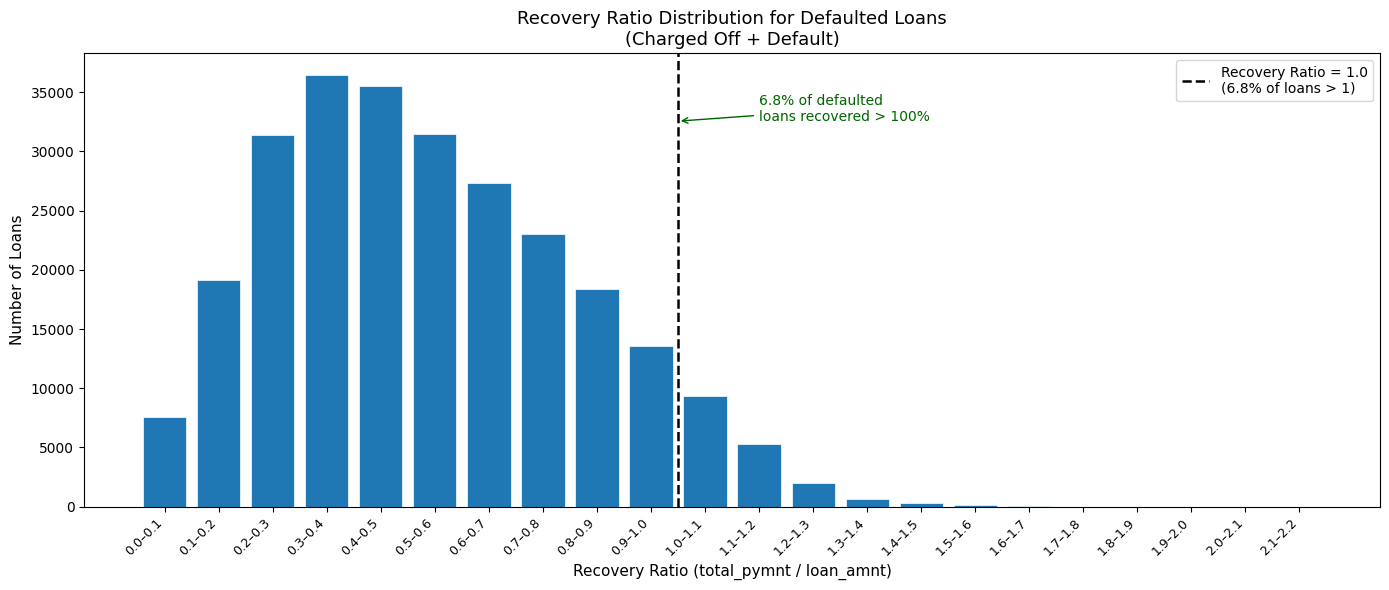

Total defaulted loans: 261,686
Loans with recovery ratio > 1: 17,847 (6.8%)
Median recovery ratio: 0.502


In [1]:
#| label: fig-default-loans-recovery-ratio
#| fig-cap: "Recovery Ratios for Default Loans."
#| echo: false
#| warning: false

%pip install kagglehub
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn


import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import os

df_orig = []


def generate_default_loans_plot():
    global df_orig

    file_path = "loan.csv"
    path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")

    csv_file = os.path.join(path, "loan.csv")
    df_orig = pd.read_csv(csv_file, low_memory=False)


    df = df_orig.copy()

    features = [
        "total_pymnt", "loan_amnt", "loan_status"
    ]
    df = df[features]

    defaulted_statuses = ["Charged Off", "Default"]
    df_default = df[df["loan_status"].isin(defaulted_statuses)].copy()

    df_default["recovery_ratio"] = df_default["total_pymnt"] / df_default["loan_amnt"]
    df_default = df_default[df_default["recovery_ratio"].notna()]
    df_default = df_default[df_default["recovery_ratio"] != float("inf")]


    max_ratio = df_default["recovery_ratio"].max()
    bins = [round(x * 0.1, 1) for x in range(0, int(max_ratio / 0.1) + 2)]
    labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins) - 1)]

    df_default["ratio_bucket"] = pd.cut(
        df_default["recovery_ratio"], bins=bins, labels=labels, right=False
    )

    bucket_counts = df_default["ratio_bucket"].value_counts().sort_index()


    pct_above_1 = (df_default["recovery_ratio"] > 1).mean() * 100


    fig, ax = plt.subplots(figsize=(14, 6))
    bars = ax.bar(range(len(bucket_counts)), bucket_counts.values, edgecolor="white", linewidth=0.5)
    ax.set_xticks(range(len(bucket_counts)))
    ax.set_xticklabels(bucket_counts.index, rotation=45, ha="right", fontsize=9)

    bucket_labels_list = list(bucket_counts.index)
    line_x = None
    for i, label in enumerate(bucket_labels_list):
        low = float(label.split("–")[0])
        if low >= 1.0:
            line_x = i - 0.5
            break

    if line_x is not None:
        ax.axvline(x=line_x, color="black", linestyle="--", linewidth=1.8, label=f"Recovery Ratio = 1.0\n({pct_above_1:.1f}% of loans > 1)")

    ax.set_xlabel("Recovery Ratio (total_pymnt / loan_amnt)", fontsize=11)
    ax.set_ylabel("Number of Loans", fontsize=11)
    ax.set_title("Recovery Ratio Distribution for Defaulted Loans\n(Charged Off + Default)", fontsize=13)
    ax.legend(fontsize=10)

    ax.annotate(
      f"{pct_above_1:.1f}% of defaulted\nloans recovered > 100%",
      xy=(line_x, ax.get_ylim()[1] * 0.85),
      xytext=(line_x + 1.5, ax.get_ylim()[1] * 0.85),
      fontsize=10,
      color="darkgreen",
      arrowprops=dict(arrowstyle="->", color="darkgreen"),
    )

    plt.tight_layout()
    plt.show()
    print(f"Total defaulted loans: {len(df_default):,}")
    print(f"Loans with recovery ratio > 1: {(df_default['recovery_ratio'] > 1).sum():,} ({pct_above_1:.1f}%)")
    print(f"Median recovery ratio: {df_default['recovery_ratio'].median():.3f}")

generate_default_loans_plot()

Rows used for correlation: 1,259,830
Columns: ['total_pymnt', 'loan_amnt', 'loan_status', 'grade', 'sub_grade', 'term', 'emp_length', 'annual_inc', 'recovery_ratio']
recovery_ratio stats:
count    1.259830e+06
mean     1.022522e+00
std      3.007604e-01
min      0.000000e+00
25%      1.027620e+00
50%      1.109975e+00
75%      1.185341e+00
max      2.170300e+00
Name: recovery_ratio, dtype: float64


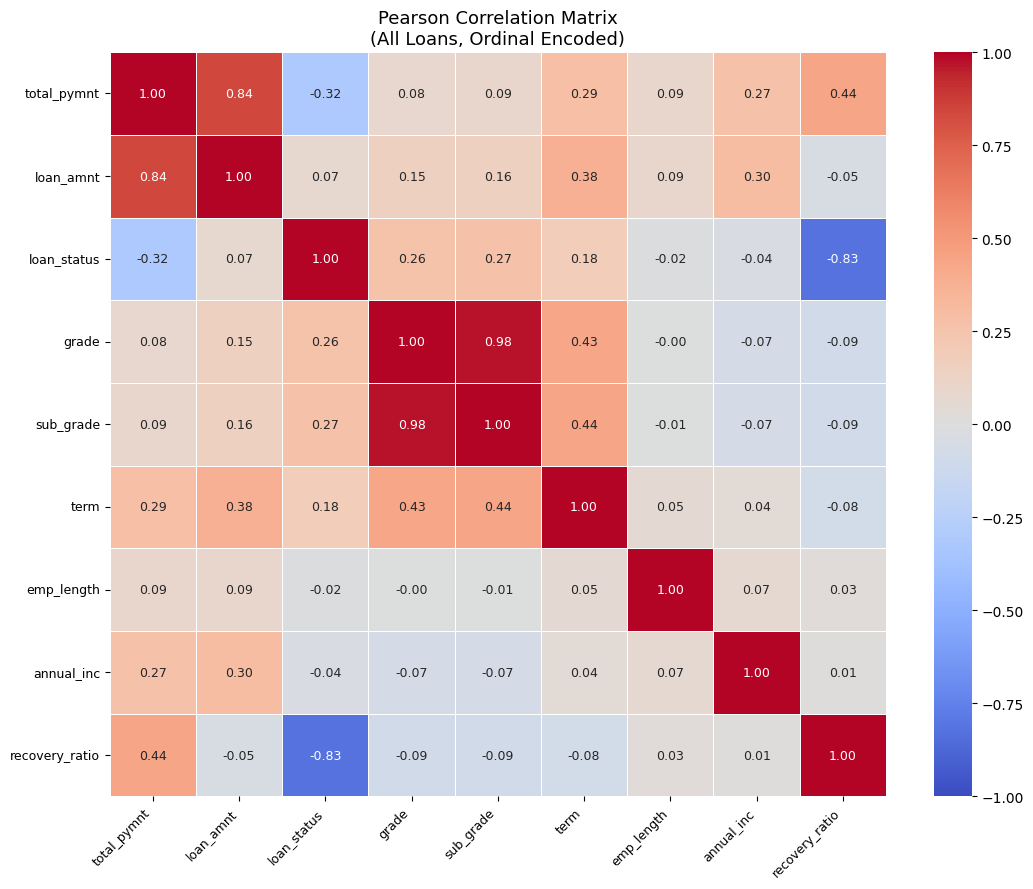


Correlations with recovery_ratio (sorted):
total_pymnt    0.438340
emp_length     0.027428
annual_inc     0.010815
loan_amnt     -0.046760
term          -0.078684
grade         -0.086880
sub_grade     -0.089503
loan_status   -0.825492


In [2]:
#| label: fig-correlation-matrix
#| fig-cap: "Correlation Matrix for Selected Features."
#| echo: false
#| warning: false

import seaborn as sns

def generate_correlation_matrix():

  global df_orig


  features = [
    "total_pymnt", "loan_amnt", "loan_status", "grade", "sub_grade",
    "term", "emp_length", "annual_inc"
  ]
  df = df_orig.copy()
  df = df[features]

  grade_order = ["A", "B", "C", "D", "E", "F", "G"]
  df["grade"] = pd.Categorical(df["grade"], categories=grade_order, ordered=True).codes + 1

  sub_grades = [f"{g}{n}" for g in ["A","B","C","D","E","F","G"] for n in range(1, 6)]
  df["sub_grade"] = pd.Categorical(df["sub_grade"], categories=sub_grades, ordered=True).codes + 1


  term_order = [" 36 months", " 60 months"]
  df["term"] = pd.Categorical(df["term"], categories=term_order, ordered=True).codes + 1

  emp_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
              "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]
  df["emp_length"] = pd.Categorical(df["emp_length"], categories=emp_order, ordered=True).codes
  df["emp_length"] = df["emp_length"].replace(-1, pd.NA)


  status_order = [
    "Fully Paid",
    "In Grace Period",
    "Late (16-30 days)",
    "Late (31-120 days)",
    "Default",
    "Charged Off"
  ]
  df["loan_status"] = pd.Categorical(df["loan_status"], categories=status_order, ordered=True).codes + 1
  df["loan_status"] = df["loan_status"].replace(0, pd.NA)


  df = df.dropna().reset_index(drop=True)


  df = df.assign(recovery_ratio=df["total_pymnt"] / df["loan_amnt"])
  df = df[df["recovery_ratio"].notna() & ~df["recovery_ratio"].isin([float("inf"), float("-inf")])]


  corr = df.corr(method="pearson")

  fig, ax = plt.subplots(figsize=(11, 9))
  mask = None

  sns.heatmap(
      corr,
      annot=True,
      fmt=".2f",
      cmap="coolwarm",
      center=0,
      vmin=-1, vmax=1,
      linewidths=0.5,
      ax=ax,
      annot_kws={"size": 9}
  )

  print(f"Rows used for correlation: {len(df):,}")
  print(f"Columns: {list(df.columns)}")
  print(f"recovery_ratio stats:\n{df['recovery_ratio'].describe()}")

  ax.set_title("Pearson Correlation Matrix\n(All Loans, Ordinal Encoded)", fontsize=13)
  plt.xticks(rotation=45, ha="right", fontsize=9)
  plt.yticks(rotation=0, fontsize=9)
  plt.tight_layout()
  plt.show()

  print("\nCorrelations with recovery_ratio (sorted):")
  print(corr["recovery_ratio"].drop("recovery_ratio").sort_values(ascending=False).to_string())

generate_correlation_matrix()